# Pneumonia classification from X-ray images
In this notebook we will train a convolutional neural network (CNN) to classify X-ray images as being from patients with or without pneumonia. The dataset (available on [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)) from Mendeley Data contains a total of 5863 X-ray images which are split into two categories; normal or pneumonia. Here we will fine-tune a pretrained ResNet-18 model.

<p align="center">
    <img src="./imgs/kaggle-xray-example.png", width="600">
</p>
<p align="center">
    <em>Illustrative example of chest X-rays in patients with pneumonia <a href="http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5">(Source) </a> .</em>
</p>

The aim of this notebook is to develop an end-to-end workflow to allow models to be trained and deployed on AWS SageMaker. We will try to get a reasonable model, but achieving the very best results is not the main objective.

In this case, I run the notebook on my local machine on VS Code. To run on a SageMaker notebook instance (or in SageMaker Studio) you will need to make some small changes, which I will try to highlight throughout the notebook.

### Running in SageMaker studio/notebook instance
Although I developed this notebook on my local machine, you should be able to run this directly in a SageMaker notebook instance or SageMaker studio. You simply need to clone this repository and make sure you select one of the `Python 3 (PyTorch 1.8)` kernels.

I'll try to point in the notebook where you may need to do things differently to how I ran it on my local machine. For instance, you will need to uncomment and run the cell below to install some additional packages that are not included in the SageMaker PyTorch image.

In [1]:
## If running in SageMaker notebook or Studio, you should uncomment this cell and run to install the additional packages required. 
# !pip install smdebug
# !pip install kaggle
# !pip install wandb
# !pip install Pillow
# !pip install wandb

## Import packages

In [26]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import CollectionConfig, DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer, NumpyDeserializer

from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import wandb
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from zipfile import ZipFile
import json
from random import sample
import shutil
import os
import IPython
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision import transforms

## Global variables and settings

Please update the variables below for your own S3 bucket and directory structure.

In [2]:
S3_BUCKET_NAME = 'robsmith155-courses' # Set this to your own AWS S3 bucket
LOCAL_HOME_DIR = '/home/robsmith155' # Home directory on your local machine. This will be used to store tokens created by Kaggle.
LOCAL_DATA_DIR = './chest_xray' # Local path where data is downloaded
S3_DATA_PREFIX = 'udacity-aws-nd/course3/project/data' # Directory to store data on S3

### SageMaker role (running on local enviornment)

Before running this you need to make sure that you have created a SageMaker execution role. See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html#sagemaker-roles-create-execution-role) for guidance on creating a SageMaker execution role in the IAM console.

Note that the role needs the following policies attached:
- AWSS3FullAccess
- AWSSageMakerFullAccess

If running from SageMaker studio, you can use the `get_execution_role` function from the SageMaker SDK to retrieve the role ARN (since a role is attached to the notebook instance). 

This is not possible if running locally, so we have two options. Either you can go to the IAM console in AWS and copy the ARN of the SageMaker execution role you want to use. The alternative is to use the `boto3` SDK to retrieve the information for the specified role name as shown below. You will need to replace this with your own SageMaker execution role.

In [14]:
iam_client = boto3.client('iam')
SAGEMAKER_ROLE_ARN = iam_client.get_role(RoleName='AmazonSageMaker-ExecutionRole-20220215T183023')['Role']['Arn']

In [15]:
print(SAGEMAKER_ROLE_ARN)

arn:aws:iam::377574710449:role/service-role/AmazonSageMaker-ExecutionRole-20220215T183023


### SageMaker role (running on SageMaker notebook instance or Studio)
If running on a SageMaker notebook instance or Studio, you have already created a SageMaker execution role. In this case, we can get the ARN of the current execution role using the `get_execution_role()` method. If running this way you can uncomment and run the cell below.

In [ ]:
# sess = sagemaker.Session()
# SAGEMAKER_ROLE_ARN = sagemaker.get_execution_role()

## Configure Weights and Biases (optional)
I've made the code so that the training jobs can be tracked in [Weights and Biases](https://wandb.ai/site). You can skip this section if you don't want to track with W&B, but make sure that the `wandb_tracking` parameter is set to 'false' in the training job hyperparameters (note this should be a string, not a Boolean).

If you would like to use this, you will need to do the following:

1. Make sure you've created a Weights & Biases account (see [here](https://wandb.ai/site))
2. Install the `wandb` Python package (if you used the environment file in this repo you should already have this)
3. Make sure you are logged into your account at www.wandb.ai, then uncomment and run the cell below. Follow the instructions to retrieve your API key.


In [ ]:
#wandb.login()

4. Create `secrets.env` file with your credentials. Simply uncomment and run the cell below.

In [ ]:
# !mkdir -p source_dir
# wandb.sagemaker_auth(path="source_dir")

An entry has been added to the `.gitignore` file so that the key will not be uploaded to your GitHub repo.

## Dataset
In this project we will work with the chest X-ray dataset for indentifying pneumonia which is available on [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

Our first job is to download the dataset and upload the extracted images to an S3 bucket so that they can be accessed by SageMaker.

### Download dataset
If running for the first time, you need to download the dataset from Kaggle. You can either go to the [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) webpage and download it manually, or you can configure the Kaggle CLI to download it.

#### Set up Kaggle API key
For the latter, you will need to login to your Kaggle account and create a new API token (if you don't already have one):

1. Go to your Kaggle account and click on your profile picture (top right corner). Select `Account`.

<p align="center">
    <img src="./imgs/create-kaggle-api1.png", width="800">
</p>
<p align="center">
    <em>Go to your Kaggle Account page.</em>
</p>


2. Create new API token

Now scroll down to the API section and click on **Create New API Token**. 

<p align="center">
    <img src="./imgs/create-kaggle-api2.png", width="800">
</p>
<p align="center">
    <em>Create new Kaggle API key.</em>
</p>

This will download a `kaggle.json` file containing your username and key. You can either put this in the correct location manually (`~/.kaggle/kaggle.json`) or you can copy the key from the file and uncomment the cells below. Note that you need to update the `kaggle_username` and `kaggle_key` fields to your own account information.

**Important**: Once the file is created, be sure to delete your Kaggle API key from the `kaggle_key` field below (if you use this method) so you don't accidentally publish it on GitHub.**

In [7]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p {LOCAL_HOME_DIR}/.kaggle
!touch {LOCAL_HOME_DIR}/.kaggle/kaggle.json
!chmod 600 {LOCAL_HOME_DIR}/.kaggle/kaggle.json

In [9]:
# Fill in your user name and key from creating the kaggle account and API token file

kaggle_username = "INSERT KAGGLE USERNAME"
kaggle_key = "INSERT KEY HERE"

# Save API token the kaggle.json file
with open(f"{LOCAL_HOME_DIR}/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

#### Download data
Now we can download the dataset using the Kaggle CLI:

In [10]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia;

100%|█████████████████████████████████████▉| 2.29G/2.29G [03:24<00:00, 13.6MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [03:24<00:00, 12.0MB/s]


This downloads a zipped file. We can extract the contents using `ZipFile`:

In [3]:
with ZipFile('chest-xray-pneumonia.zip', 'r') as zipObj:
   # Extract all the contents of zip file
   zipObj.extractall();

### Check number of files extracted

In [61]:
num_train_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/train/NORMAL'))
num_train_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/train/PNEUMONIA'))
num_training_samples = num_train_samples_pneumonia + num_train_samples_normal

num_val_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/val/NORMAL'))
num_val_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/val/PNEUMONIA'))
num_val_samples = num_val_samples_pneumonia + num_val_samples_normal

num_test_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/test/NORMAL'))
num_test_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/test/PNEUMONIA'))
num_test_samples = num_test_samples_pneumonia + num_test_samples_normal

print(f'Total training samples: {num_training_samples}')
print(f'Total validation samples: {num_val_samples}')
print(f'Total test samples: {num_test_samples}')

Total training samples: 5216
Total validation samples: 16
Total test samples: 624


As we can see, the validation set is tiny. I have no idea why they split the data in this way, but 16 samples is not really sufficient for us to evaluate the model performance.

### Move some samples from test to validation dataset

We could move some of the training samples to the validation set, but we already have a very small dataset to train with (5216 X-rays). Instead I will move some of the test images to the validation dataset so that they have an equal number of samples. To do this I'll randomly sample from the test dataset, taking the same proportion of images from the normal and pneumonia folders. We'll look into issues of class imbalance later. I'm making an assumption here that the validation and test datasets belong to the same distribution as the training data.

In [60]:
num_val_test_images = num_test_samples_normal + num_test_samples_pneumonia + num_val_samples_normal + num_val_samples_pneumonia
print(f'Total validation + test images: {num_val_test_images}')

Total validation + test images: 640


We'll aim here to have approximately the same number of images in the validation and test datasets. We have a total of 640 images in these two sets, so we want to have around 320 in each.

In [62]:
num_images_to_move = 320 - num_val_samples
proportion_pneumonia_test = num_test_samples_pneumonia / num_test_samples
proportion_normal_test = 1 - proportion_pneumonia_test
num_pneumonia_to_move = round(num_images_to_move * proportion_pneumonia_test)
num_normal_to_move = round(num_images_to_move * proportion_normal_test)

print(f'Number of pneumonia images to move: {num_pneumonia_to_move}')
print(f'Number of normal images to move: {num_normal_to_move}')

Number of pneumonia images to move: 190
Number of normal images to move: 114


Now we will randomly select these images from the test folders and move them to the validation directory.

In [65]:
def move_images(from_dir, to_dir, num_images):
    img_files = os.listdir(from_dir)
    img_files_move = sample(img_files, num_images)
    for file in img_files_move:
        from_path = os.path.join(from_dir, file)
        to_path = os.path.join(to_dir, file)
        shutil.move(from_path, to_path)

In [66]:
normal_test_dir = f'{LOCAL_DATA_DIR}/test/NORMAL'
normal_val_dir = f'{LOCAL_DATA_DIR}/val/NORMAL'
move_images(normal_test_dir, normal_val_dir, num_normal_to_move)

In [67]:
pneumonia_test_dir = f'{LOCAL_DATA_DIR}/test/PNEUMONIA'
pneumonia_val_dir = f'{LOCAL_DATA_DIR}/val/PNEUMONIA'
move_images(pneumonia_test_dir, pneumonia_val_dir, num_pneumonia_to_move)

Let's check that we have the expected number of validation and test images:

In [68]:
num_val_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/val/NORMAL'))
num_val_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/val/PNEUMONIA'))
num_val_samples = num_val_samples_pneumonia + num_val_samples_normal

num_test_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/test/NORMAL'))
num_test_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/test/PNEUMONIA'))
num_test_samples = num_test_samples_pneumonia + num_test_samples_normal

print(f'Total training samples: {num_training_samples}')
print(f'Total validation samples: {num_val_samples}')
print(f'Total test samples: {num_test_samples}')

Total training samples: 5216
Total validation samples: 320
Total test samples: 320


### Upload to S3 bucket
To train the model on AWS SageMaker, the data needs to be in an S3 bucket. We can upload the data by creating a session with the `sagemaker` SDK and then using the `upload_data()` method.

In [5]:
sagemaker_session = sagemaker.Session(default_bucket=S3_BUCKET_NAME)

Let's check that we have the correct bucket and region for the session:

In [6]:
sagemaker_session.default_bucket(), sagemaker_session._region_name

('robsmith155-courses', 'us-east-1')

Now we upload all of the data to the S3 bucket.

In [71]:
inputs = sagemaker_session.upload_data(path=LOCAL_DATA_DIR, bucket=S3_BUCKET_NAME, key_prefix=S3_DATA_PREFIX)
print(f"Data has been uploaded to: {inputs}")

Data has been uploaded to: s3://robsmith155-courses/udacity-aws-nd/course3/project/data


### Check data in bucket

We can use the Boto3 SDK to connect to S3 and check that the data has been uploaded. Boto3 provides a Python API for AWS infrastructure services.

In [72]:
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=S3_BUCKET_NAME, Prefix=S3_DATA_PREFIX)['Contents']

Let's take a look at the first item in the retrieved contents:

In [73]:
contents[0]

{'Key': 'udacity-aws-nd/course3/project/data/test/NORMAL/IM-0001-0001.jpeg',
 'LastModified': datetime.datetime(2022, 3, 25, 11, 51, 53, tzinfo=tzutc()),
 'ETag': '"6535e4c9b865af758eb077d28864c334"',
 'Size': 252680,
 'StorageClass': 'STANDARD',
 'Owner': {'DisplayName': 'robsmith155',
  'ID': 'b9edd0ce8767426bd11f3546255f6f1e61fc62f411bbd6bcdf3cdd0d99570ae3'}}

In [74]:
len(contents)

1000

Note that by default the `list_objects` method returns a maximum of 1000 objects. Below I print the path of the first five objects retrieved.

In [75]:
for i in range(5):
    print(contents[i]['Key'])

udacity-aws-nd/course3/project/data/test/NORMAL/IM-0001-0001.jpeg
udacity-aws-nd/course3/project/data/test/NORMAL/IM-0006-0001.jpeg
udacity-aws-nd/course3/project/data/test/NORMAL/IM-0013-0001.jpeg
udacity-aws-nd/course3/project/data/test/NORMAL/IM-0016-0001.jpeg
udacity-aws-nd/course3/project/data/test/NORMAL/IM-0029-0001.jpeg


So it looks like the data has been uploaded correctly to the S3 bucket.

## EDA
Now let's take a look at the data to identify any issues that can help us to understand the pre-processing workflow that is required before training a model.

### Class distribution
First let's look at the distribution of the images to determine whether we have a balanced dataset or not.

Text(0.5, 1.0, 'Proportion of normal-pneumonia images for each dataset')

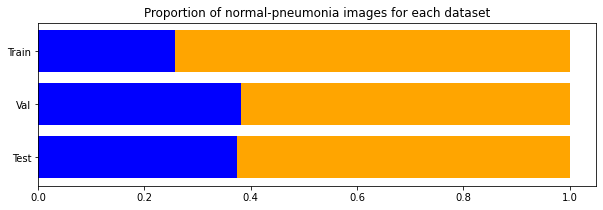

In [92]:
fig = plt.figure(figsize=(10,3))

plt.barh('Test', width = num_test_samples_normal / num_test_samples, color='b')
plt.barh('Test', width = num_test_samples_pneumonia / num_test_samples, color='orange', left = num_test_samples_normal / num_test_samples)
plt.barh('Val', num_val_samples_normal / num_val_samples, color='b')
plt.barh('Val', num_val_samples_pneumonia / num_val_samples, color='orange', left=num_val_samples_normal / num_val_samples)
plt.barh('Train',num_train_samples_normal / num_training_samples, color='b')
plt.barh('Train', num_train_samples_pneumonia / num_training_samples, color='orange', left=num_train_samples_normal / num_training_samples)
plt.title('Proportion of normal-pneumonia images for each dataset')

So we can see that the dataset is imbalanced, particularly for the training dataset. Here we have around three pneumonia examples for every normal X-ray. If we don't account for this then a model may be biased towards the dominant class (which in this case is X-rays with pneumonia). The training and validation datasets are not quite as bad, with around two pneumonia X-rays for every normal sample.

### Plot random sample of images

The function below will plot nine random X-ray images from the directory that is passed to the function. Along with the image it will also print the image dimensions to help us understand what we are working with.

In [85]:
def plot_sample_xrays(data_dir: str):
    img_names =  os.listdir(data_dir)
    files = sample(img_names, 9)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.suptitle('Example X-ray images')
    for file, ax in zip(files, axes.ravel()):
        img_path = os.path.join(data_dir, file)
        img = np.array(Image.open(img_path))
        img_height, img_width = img.shape
        
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Image size (w x h): {img_width} x {img_height} pixels')

#### Sample of normal X-rays

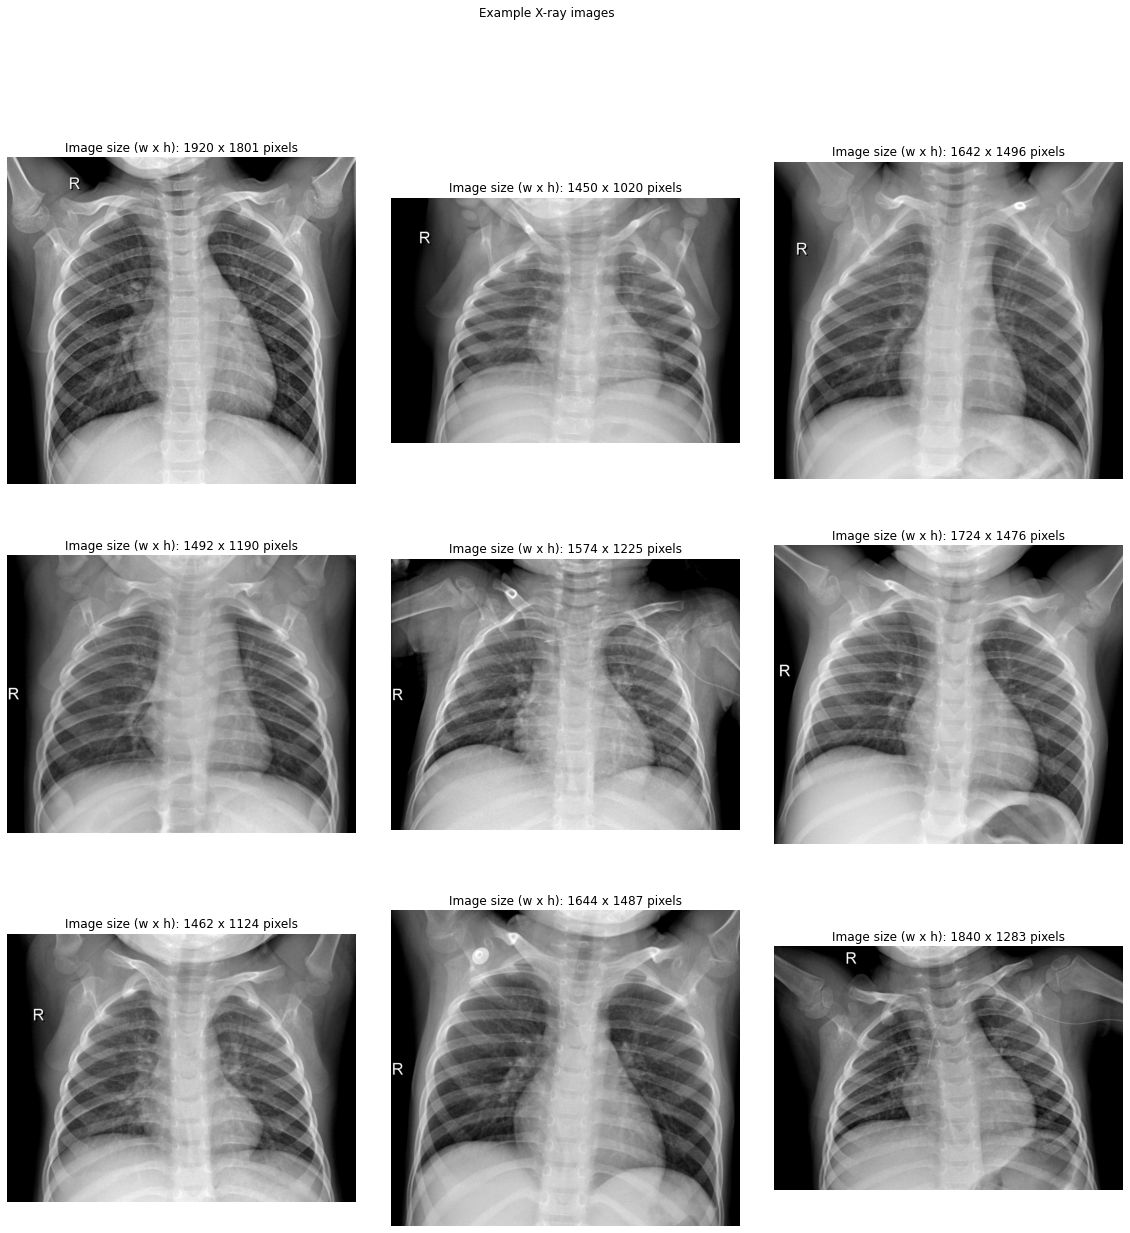

In [86]:
plot_sample_xrays(f'{LOCAL_DATA_DIR}/train/NORMAL')

#### Sample of X-rays with pneumonia

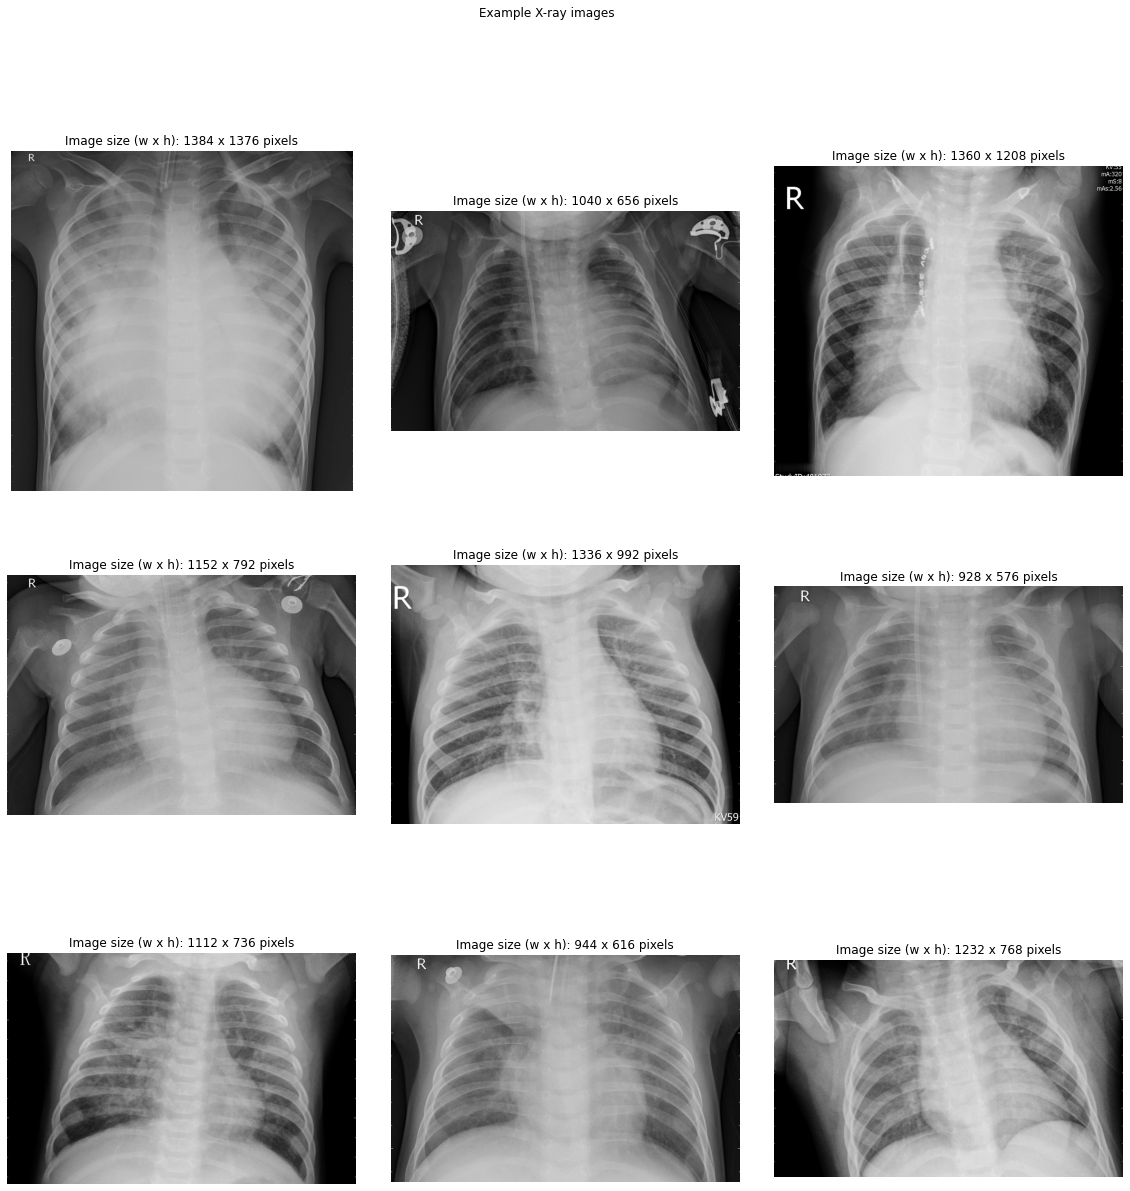

In [88]:
plot_sample_xrays(f'{LOCAL_DATA_DIR}/train/PNEUMONIA')

### Observations
We can see that in general, compared to the normal X-rays, those classified as pneumonia are less clear (i.e. increased opacity). Apparently, a radiologist will look for white spots in the lungs (known as infiltrates) that are indicative of infection [(source)](https://www.radiologyinfo.org/en/info/pneumonia). Another useful source for radiology interpretation can be found [here](https://radiologyassistant.nl/chest/chest-x-ray/lung-disease).

A number of issues that need to be addressed during pre-processing are identified from these example images:
- The images are large, with many dimensions being more than 1000 pixels in size. For convolutional neural networks we typically use images of 256 x 256 pixels or less.
- The images are different sizes
- The images are not square, so when we resize we'll have to take a crop of the image
- We have a small training dataset, so we should use data augmentation to increase the data variation
- Imbalanced dataset - we have more X-rays showing pneumonia than normal X-rays
- Images are single channel (i.e. grayscale) while models pretrained on ImageNet expect three channel (i.e. RBG) inputs

We will need to take care of some of these issues when building the preprocessing pipeline.

## Develop PyTorch DataLoader

In PyTorch, we need to use a Dataset and DataLoader to pass data to the model. In this section we will develop these to try and account for some of the issues identified in the previous section. We will also make sure the outputs are as expected before going on to train a model.

### Develop image augmentation workflow
For the training data, we can use image augmentation to allow the network to see more variations than are present in X-ray images we have been provided with. This can help to overcome the challenges faced with small datasets. We also need to take care of the fact that the images are single channel and are very large in size.

First let's load an example image to work with.

In [55]:
def jpeg_loader(f):
    """Loads a 16-bit tiff image and returns it as a numpy array.

    """
    with open(f, 'rb') as f:
        image = Image.open(f)
        return np.array(image)

In [56]:
local_train_normal_dir = f'{LOCAL_DATA_DIR}/train/NORMAL'
im_file = os.listdir(local_train_normal_dir)[0]
img = jpeg_loader(os.path.join(local_train_normal_dir, im_file))

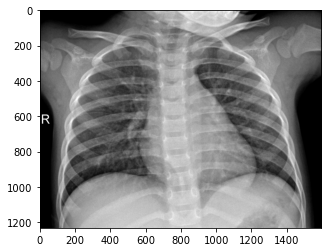

In [58]:
plt.imshow(img, cmap='gray')

Now we will create a series of transformations for the image using tools from the `torchvision.transforms` package. This includes:
- **Grayscale**: The X-ray data are single channel (i.e. grayscale) images. However, the pretrained model we wil work with was trained on RGB (i.e. three-channel) images. To make the inputs the appropriate shape, this transformation will copy the image to make it three channels.
- **RandomResizedCrop**: This will will take a crop of the original image (0.85-1x the original) and then resize it to a 256x256 square image.
- **RandomRotation**: Adds a small random amount of rotation as this doesn't effect the interpretation of the image. We don't want to add too much though.
- **RandomHorizontalFlip**: Randonly flips the image. A horizontal flip doesn't alter the prognosis, so we can include this to add additional variation. Vertical flips would not be suitable as we won't have upside down X-ray images.
- **CenterCrop**: We take a central crop as the main focus should be in the center of the image. It is resized to 224x224 pixels as this is the expected input size for the pretarined ResNet18 model.



In [59]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(size=256, scale=(0.85, 1.0)),
    transforms.RandomRotation(degrees=5, expand=True),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.CenterCrop(size=224)
    ])

Torchvision doesn't accept NumPy arrays as input, so let's first convert the image back to a Pillow image type:

In [60]:
img = Image.fromarray(img)

Now pass it through the transformation twice and plot the results.

In [61]:
# torch transform returns a 3 x W x H image, we only show one color channel
augmented_image_1 = transform(img)
augmented_image_2 = transform(img)

Text(0.5, 1.0, 'Augmented image 2')

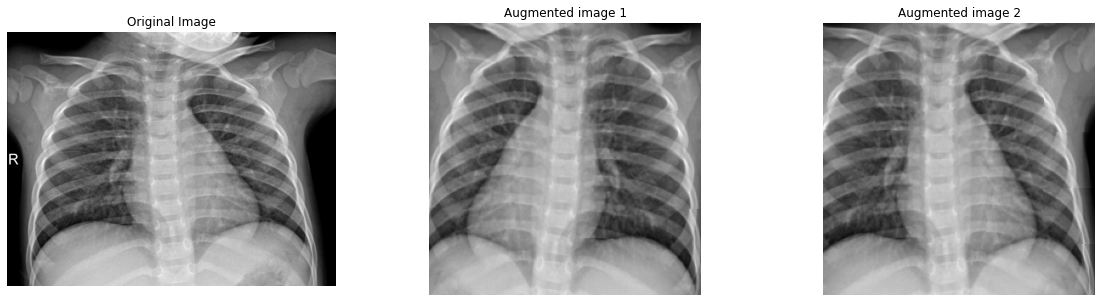

In [62]:

fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs[0].imshow(img, cmap='gray')
axs[0].set_axis_off()
axs[0].set_title('Original Image')

axs[1].imshow(augmented_image_1, cmap='gray')
axs[1].set_axis_off()
axs[1].set_title('Augmented image 1')

axs[2].imshow(augmented_image_2, cmap='gray')
axs[2].set_axis_off()
axs[2].set_title('Augmented image 2')

So we can see that we now have two slightly different views of the input image which may help the model to generalize better to images that it has not seen before.

### Create Dataset and DataLoader
Here I'll create the DataLoader and check that the outputs look okay. The training transforms are the same as the last part, except that we also add two additional steps. The `ToTensor()` step will convert the data to PyTorch tensors and put them in the range of [0,1]. Then the `Normalize` method is used to normalize the data. Note that the mean and standard deviation values are the statistics from the ImageNet dataset.

In [63]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(size=256, scale=(0.85, 1.0)),
    transforms.RandomRotation(degrees=5, expand=True),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

We should not apply all of these transformations for the validation dataset. In this case, we only need to apply certain steps to make sure the image has three channels and is the correct size. Here we don't apply any image augmentation steps such as horizontal flipping and rotation.

In [64]:
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

We can use the `ImageFolder` class from torchvision to generate a PyTorch dataset based on a folder containing images. This will recognize the subdirectories and use the name of these as the labels.

In [65]:
train_dataset = ImageFolder(
    './chest_xray/train', 
    transform=train_transforms)

In [66]:
val_dataset = ImageFolder(
    './chest_xray/val', 
    transform=val_transforms)

In [67]:
len(train_dataset), len(val_dataset)

(5216, 320)

Now we use the Datasets to create a PyTorch DataLoader which we will iterate over during training. 

In [68]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True
)

In [69]:
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=True
)

### QC outputs from DataLoader

We can can get a batch of data from a DataLoader as shown below:

In [70]:
batch = next(iter(train_dataloader))

In [71]:
len(batch), batch[0].shape, batch[1].shape

(2, torch.Size([16, 3, 224, 224]), torch.Size([16]))

This contains two parts. the first element is a PyTorch tensor containing the image data. Note that we have 16 images (the batch size) and the images have dimensions of 3x224x224. PyTorch expects images to be ordered as CxHxW, so this is correct.

In [100]:
batch[0][0].shape

torch.Size([3, 224, 224])

The second part is the labels which have been converted to a PyTorch tensor. Here, 0 represents a normal X-ray while 1 is an image with pneumonia.

In [101]:
batch[1].data

tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

Lets plot a histogram of the image data to make sure that the values are in the expected range.

(array([  660.,  1266.,  3718.,  9164., 16684., 21737., 30026., 35936.,
        26636.,  4701.]),
 array([-1.6555357 , -1.3009276 , -0.9463196 , -0.5917116 , -0.2371035 ,
         0.11750454,  0.4721126 ,  0.82672065,  1.1813287 ,  1.5359367 ,
         1.8905448 ], dtype=float32),
 <BarContainer object of 10 artists>)

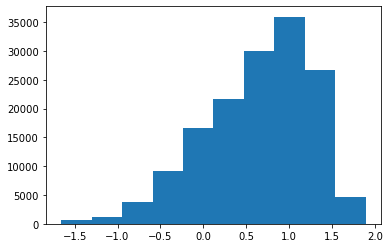

In [102]:
plt.hist(batch[0][0].numpy().flatten())

Although skewed, the values are not in an unexpected range, so this is probably okay. Remember we are normalizing using the ImageNet data statistics rather than those of the X-ray dataset, which may be one reason for this.

Finally, lets plot some outputs images from the DataLoader and the corresponding labels.

In [75]:
def plot_dataloader_imgs(dataloader, num_images):
    batch = next(iter(dataloader))
    imgs = batch[0][:num_images]
    labels = batch[1][:num_images]
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(15,5))
    for i in range(num_images):
        img = imgs[i].numpy()   
        img = np.transpose(img, (1,2,0))
        axs[i].imshow(img[:,:,0], cmap='gray')
        if labels[i].numpy() == 0:
            label = 'Normal'
        elif labels[i].numpy() == 1:
            label = 'Pneumonia'
        axs[i].set_title(label)


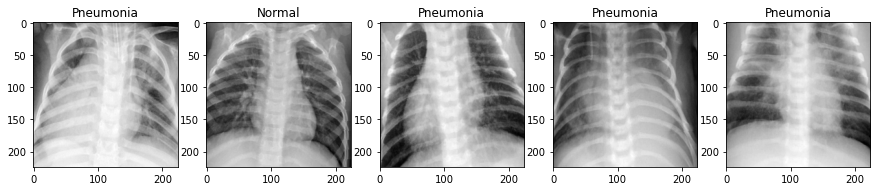

In [76]:
plot_dataloader_imgs(train_dataloader, 5)

## Model training
Now we are ready to train our model. In this example, we will fine-tune a pretrained [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) model. 

<p align="center">
    <img src="./imgs/structure-of-resnet18.png", width="600">
</p>
<p align="center">
    <em>Basic structure of ResNet18 architecture <a href="https://www.researchgate.net/publication/340644618_Transfer_Learning_with_Deep_Convolutional_Neural_Network_CNN_for_Pneumonia_Detection_using_Chest_X-ray">(Source) </a> .</em>
</p>

The final linear classifier is replaced with a new linear layer to be suitable for this binary classification challenge (i.e. we use a single neuron as the output). Here I used [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) so we don't need to apply an activation function at the end of the network. This will layer combines both the Sigmoid layer and BCELoss in a single class and tends to be more stable. This means that the loss expects the labels to be floats (not Long), so we need to ensure that the labels are the correct format. When it comes to making a prediction, if we take a raw logit, any negative value corresponds to the 0 class (normal), while a positive logit would be predicted as the positive (pneumonia) class, assuming we use a threshold of 50% as the decision boundary.

For training, all of the convolutional layers are frozen, so only the weights of the linear classifier at the end of the model are updated. One area for improvement would be to also fine-tune the convolutional layers (but here different learning rates should be used, with smaller values for earlier layers).

### Training script
The code to fine-tune a pretrained model is contained in the `train_model.py` file. This includes options to log the results in Weights & Biases, as well as running SageMaker debugging and profiling. 

Some of the important parameters are mentioned below:

- `output_dir`: This is the path of the S3 directory where you want to store the outputs of the training job. Within the script, this is used to set the `SM_OUTPUT_DATA_DIR` environment variable. Once training is finished on the EC2 instance, the outputs will be copied to this location.
- `wandb_tracking`: If you want to track with W&B (and you followed the instructions above to configure your account), you can set this argument to 'true' (string, not boolean. See next section) and the metrics of the training jobs will be automatically logged for you.
- `debugging`: Whether you want to run SageMaker debugging with the training job. Set this to 'true' (string, not Boolean) if you want to use it.
- `profiler`: Whether you want to run SageMaker profiling with the training job. Set this to 'true' (string, not Boolean) if you want to use it.

#### Boolean parameters
It's worth mentioning the issue of using Boolean hyperparameters with SageMaker, since this is something that I found to be poorly documented. Initially I was including Boolean arguments with Argparse like shown below:

```
parser.add_argument(
        "--debugging",
        type=bool,
        default=False,
        help="Run debugging (default: False)"
    )
```
Initially I thought everything was fine as my script was running. However, I discovered in the AWS CloudWatch logs that these were always being picked up as `True`, even if I explicitly passed `False` to the argument. This issue is not well explained in the Sagemaker documentation, the only reference I can find is the following excerpt:

> Note that SageMaker doesn’t support argparse actions. If you want to use, for example, boolean hyperparameters, you need to specify type as bool in your script and provide an explicit True or False value for this hyperparameter when instantiating PyTorch Estimator. [(Source)](https://sagemaker.readthedocs.io/en/v2.21.0/frameworks/pytorch/using_pytorch.html)

I eventually found a workaround based in [this](https://github.com/awslabs/sagemaker-debugger/blob/master/examples/tensorflow/sagemaker_byoc/simple.py) example. In the training script I include the following function to convert certain strings to Booleans:

```
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ("yes", "true", "t", "y", "1"):
        return True
    elif v.lower() in ("no", "false", "f", "n", "0"):
        return False
    else:
        raise argparse.ArgumentTypeError("Boolean value expected.")
```

Now we set the type of the parameter to be `str2bool` as follows:

```
parser.add_argument(
        "--debugging",
        type=str2bool,
        default=False,
        help="Run debugging (default: False)"
    )
```
We should then pass a valid string (such as 'true' or 'false'), depending on which Boolean we need.

```
hyperparameters={
        ...
        "debugging": 'false',
        ...}
```

I'm still not exactly clear on the issues behind this, but at least this seems to work for now.

### Debugger profiling report
Before we run a hyperparameter search we should run a small test to make sure that we don't have any major issues. SageMaker Debugger allows us to profile and debug training jobs to help us find issues and bottlenecks within the code. We can then fix these before running many training jobs.

The Debugger for training jobs is well documented [here](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html). You can also refer to [this](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_profiling/pt-resnet-profiling-single-gpu-single-node.ipynb) example notebook for creating a debugging profile report for a PyTorch job.

#### Configure Debugger built-in rules
We can make use of some built-in rules provided by AWS to analyze tensors output during model training. We can set these using the `Rule` API. This includes rules to determine if the gradients are getting too large/small and whether the model is overfitting. See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/use-debugger-built-in-rules.html) for a full set of the rules available.

The **ProfilerReport** will run these rules and automatically generate a report which highlights issues and provides recommendations for improvement.

In [77]:
# Set up debugging and profiling rules and hooks
rules = [Rule.sagemaker(rule_configs.vanishing_gradient()),
         Rule.sagemaker(rule_configs.overfit()),
         Rule.sagemaker(rule_configs.overtraining()),
         Rule.sagemaker(rule_configs.poor_weight_initialization()),
         Rule.sagemaker(rule_configs.loss_not_decreasing()),
         ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
         ProfilerRule.sagemaker(rule_configs.ProfilerReport())]

#### Configure Debugger monitoring hardware resource utilization and framework profiling
For this we can use the `ProfilerConfig` API. Below we configure the profiler to capture system information (such as CPU and GPU usage) every 500 ms and capture detailed framework profiling information for 10 steps. This will include thing such as data loader processes and Python operators.

In [78]:
profiler_config = ProfilerConfig(system_monitor_interval_millis=500,
                                 framework_profile_params=FrameworkProfile(num_steps=10))

#### Configure Debugger tensor collections
We can have Debugger output tensor information for us during training using the `CollectionConfigAPI`. In the configuration below, I just output the weights of the network. I was having issues outputing other tensor data,such as biases and gradients. See [here](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) for a full list of Debugger built-in collections.

In [79]:
collection_configs=[
        CollectionConfig(name="weights")
    ]

We need to tell SageMaker where to save the outputs of the debugging.

In [6]:
s3_output_dir = f's3://{S3_BUCKET_NAME}/udacity-aws-nd/course3/project/outputs/'

We then pass this to the `DebuggerHookConfig` class to save the tensors for us.

In [80]:
debugger_config = DebuggerHookConfig(
    collection_configs=collection_configs,
    s3_output_path= s3_output_dir,
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"})

#### Setup Estimator
Now we can configure a `PyTorch` estimator for training a model.

A few things to note:
- **entry_point**: Points to to the script that will be run to train the model (in this case `train_model.py`). This is only required when we want to use our custom scripts, as is the case here.
- **source_dir**: If we want to include more than just a script to run training we can put them inside a dedicated directory. In this case we have a folder named `source_dir` which is in this repo. For instance, here we can include a `requirements.txt` file which includes any packages that are not installed in the AWS PyTorch image environment. In this case I want to track using Weights & Biases so I included the `wandb` package.
- **instance_type**: Here I am using the `ml.p2.xlarge` instance type as it is what I have available in my account. This uses an NVIDIA K80 GPU, which is not the best but will do for now. Note that by default you will not have access to this instance type, so you may need to contact AWS support to increase your allowance.
- **instance_count**: Ideally I would run on more than one instance, but I only have one available.
- **use_spot_instances**:  For the case of debugging, I'll use the normal instance since I want to be able to debug quickly. I'll use spot instances for hyperparameter tuning.
- **profiler_config**: This configures the Debugger to collect system and framework metrics from the training job.
- **debugger_hook_config**: Configures Debugger to collect output tensors from the training job and save to the S3 bucket.
- **rules**: Here we can configure Debugger to enable built-in rules that automatically analyze the training job and find issues. 


We pass all of the parameters to the `train_model.py` script as a dictionary to the `hyperparameters` argument. This includes arguments for `debugging` and `profiler` which will run SageMaker debugging and profiling if set to `true`. Note that passing booleans (i.e. True, False) causes issues with SageMaker (that I don't fully understand), so we need to pass these as strings (e.g. 'true', 'false'). 

In [7]:
s3_model_dir = f's3://{S3_BUCKET_NAME}/udacity-aws-nd/course3/project/models/'

In [81]:
estimator = PyTorch(
    entry_point='train_model.py',
    source_dir='./source_dir',
    role=SAGEMAKER_ROLE_ARN,
    py_version='py3',
    framework_version='1.8',
    instance_type='ml.p2.xlarge',
    instance_count=1,
    use_spot_instances=False,
    max_run=3600,
    checkpoint_s3_uri=s3_model_dir,
    output_path=s3_output_dir,
    base_job_name='x-ray-pneumonia-debug-profile',
    hyperparameters={
        "epochs": 5, 
        "output_dir": s3_output_dir,
        "wandb_tracking": 'true', 
        "wandb_project_name": 'udacity-nd_aws-ml-engineer_project3_xray-classification',
        "early_stopping": 'true',
        "patience": 10,
        "lr": 0.001,
        "batch_size": 128,
        "debugging": 'true',
        "profiler": 'true'
        },
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
    )


#### Train model

Now we are ready to train the model. For this we just need to pass the S3 bucket location of the training and validation data to the `fit()` method.

In [43]:
training_path = f's3://{S3_BUCKET_NAME}/{S3_DATA_PREFIX}/train'
validation_path = f's3://{S3_BUCKET_NAME}/{S3_DATA_PREFIX}/val/'

In [83]:
estimator.fit(inputs={'train': training_path,'val': validation_path}, wait=True) 


2022-04-02 15:25:51 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-04-02 15:26:51 Starting - Preparing the instances for training......
2022-04-02 15:28:01 Downloading - Downloading input data.........
2022-04-02 15:29:32 Training - Downloading the training image........................
2022-04-02 15:34:04 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-02 15:34:07,939 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-02 15:34:07,964 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-02 15:34:07,975 sagemaker_pytorch_container.training INFO     Invoking user 

#### Plot a debugging output

Let's retrieve some tensor information that was saved by the Debugger. For this we can use the `smdebug` library. The example below shows how to retrieve the tensor names, which correspond to the layers of the ResNet18 model.

In [86]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2022-04-02 18:59:29.352 DESKTOP-T8O836C:10544 INFO s3_trial.py:42] Loading trial debug-output at path s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-15-25-48-961/debug-output
[2022-04-02 18:59:32.100 DESKTOP-T8O836C:10544 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-04-02 18:59:33.283 DESKTOP-T8O836C:10544 INFO trial.py:210] Loaded all steps


['BCEWithLogitsLoss_output_0',
 'ResNet_bn1.weight',
 'ResNet_conv1.weight',
 'ResNet_fc.0.weight',
 'ResNet_layer1.0.bn1.weight',
 'ResNet_layer1.0.bn2.weight',
 'ResNet_layer1.0.conv1.weight',
 'ResNet_layer1.0.conv2.weight',
 'ResNet_layer1.1.bn1.weight',
 'ResNet_layer1.1.bn2.weight',
 'ResNet_layer1.1.conv1.weight',
 'ResNet_layer1.1.conv2.weight',
 'ResNet_layer2.0.bn1.weight',
 'ResNet_layer2.0.bn2.weight',
 'ResNet_layer2.0.conv1.weight',
 'ResNet_layer2.0.conv2.weight',
 'ResNet_layer2.0.downsample.0.weight',
 'ResNet_layer2.0.downsample.1.weight',
 'ResNet_layer2.1.bn1.weight',
 'ResNet_layer2.1.bn2.weight',
 'ResNet_layer2.1.conv1.weight',
 'ResNet_layer2.1.conv2.weight',
 'ResNet_layer3.0.bn1.weight',
 'ResNet_layer3.0.bn2.weight',
 'ResNet_layer3.0.conv1.weight',
 'ResNet_layer3.0.conv2.weight',
 'ResNet_layer3.0.downsample.0.weight',
 'ResNet_layer3.0.downsample.1.weight',
 'ResNet_layer3.1.bn1.weight',
 'ResNet_layer3.1.bn2.weight',
 'ResNet_layer3.1.conv1.weight',
 'Res

The shape of an example layer is shown below:

In [91]:
trial.tensor('ResNet_layer1.0.conv1.weight').values()[0].shape

(64, 64, 3, 3)

We can also plot the tensors if we wish, such as the weights below.

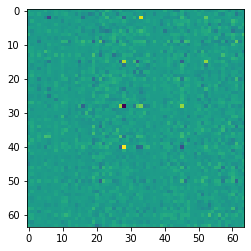

In [92]:
plt.imshow(trial.tensor('ResNet_layer1.0.conv1.weight').values()[0][:,:,0,0])

#### Display profiler output

Here we plot some of the information captured by the system profiler (such as CPU and GPU utilization). Note that Weights and Biases does a good job of capturing some of this information for every training job by default (if tracking your experiments).

In [98]:
session = boto3.session.Session()
region = session.region_name
training_job_name = estimator.latest_training_job.name

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

ProfilerConfig:{'S3OutputPath': 's3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-15-25-48-961/profiler-output


Profiler data from system is available
[2022-04-02 19:29:56.525 DESKTOP-T8O836C:10544 INFO metrics_reader_base.py:134] Getting 

#### Download report

An automated report is generated by Debugger. Below we download the files recursively using the `aws s3 cp` command. This will download the report files to your local directory.

In [44]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output
2022-04-02 09:43:44     444829 udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-04-02 09:43:43     305085 udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-04-02 09:43:39        192 udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-04-02 09:43:39     102168 udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-04-02 09:43:39       1966 udacity-aws-nd/course3/

This downloads the report in a folder named `ProfilerReport/profiler-output`. Although we can import the report into the notebook, I find this causes issues with the notebook formatting, so it's better to just open either the `profiler-report.html` file in a web browser or the `profiler-report.ipynb` notebook that is also autogenerated. 

A snapshot from the report is provided below. There are no major issues. The rule that was triggered the most is the `GPUMemeoryIncrease` check. This was triggered 61 times out of 3578 data points. It might be better to use a different instance type with a better GPU/larger memory, such as the `ml.p3.xlarge` instances. However, this will take time to setup since I need to request AWS support to add this to my available resources and will also cost more money. For now I will stick with the `ml.p2.xlarge` instance.

One thing that we can do is increase the number of workers available for the PyTorch DataLoader. For this test it was left at the default (0, meaning one it uses the main process), but I have four CPUs available on this instance type so we can increase the number of workers.

<p align="center">
    <img src="./imgs/aws-report.png", width="800">
</p>
<p align="center">
    <em>Screenshot of SageMaker debugging report.</em>
</p>


If you really want to load the report into this notebook, then uncomment the cell below and run it.

In [ ]:
# # get the autogenerated folder name of profiler report
# profiler_report_name = [
#     rule["RuleConfigurationName"]
#     for rule in estimator.latest_training_job.rule_job_summary()
#     if "Profiler" in rule["RuleConfigurationName"]
# ][0]
# IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Hyperparameter Tuning
Here we will run a small hyperparameter search to tune the learning rate and batch size for the final model. Since we are just trying to demonstrate the workflow, I only run this for a limited number of epochs and trials to keep costs low. In reality we would want to run more jobs to find the optimum set of hyperparameters.

**Note:** We won't run debugging during the hyperparameter tuning, so we can set the `debugging` and `profiler` parameters to 'false' (again, this needs to be passed as a string, not a boolean).

#### Hyperparameter search space
We specify the hyperparameters we want to serach over in a dictionary like shown below. In this example, I will just search over the learning rate and batch size, but typically we may include more parameters. 

In [106]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
}

#### Defining and capturing metrics
The tuning job needs a performance metric to enable it to decide what parameters to try next (the search uses Bayesian optimization by default). During training we need to print this information to the AWS logs and then tell the hyperparameter tuner how to retrieve this information using regex expressions. 

As you can see below, I'm using the validation F1 score as my evaluation metric. In the `train_model.py` code, the following line is included to log the validation loss and metrics:

```
logger.info(f'Val_epoch {epoch}: Val_loss={val_loss}, Val_f1={val_f1}; Val_accuracy={val_acc}; Patience={_patience}')
```

An example of what the output of this looks like in the AWS Cloudwatch logs is shown below.

<p align="center">
    <img src="./imgs/cloudwatch-training-log.png", width="800">
</p>
<p align="center">
    <em>Example training log in AWS CloudWatch with validation loss and metrics.</em>
</p>


In [107]:

objective_metric_name = "validation:f1"
objective_type = "Maximize"
metric_definitions=[
       {'Name': 'train:accuracy', 'Regex': 'Train_accuracy=(.*?);'},
       {'Name': 'validation:accuracy', 'Regex': 'Val_accuracy=(.*?);'},
       {'Name': 'train:f1', 'Regex': 'Train_f1=(.*?);'},
       {'Name': 'validation:f1', 'Regex': 'Val_f1=(.*?);'}
    ]

See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html) for more information about capturing metrics from AWS logs.

#### Configure PyTorch estimator
This is laregely the same as what we saw in the Debugger section, except that we don't include the arguments for the debugging and set the `debugging` and `profiler` parameters to 'false' in the hyperparameters for the `train_model.py` script.

In this case I will use spot instances as they are a lot cheaper to run (typically around 70% less). Note that you need to request spot instance allowance from AWS support for some reason (i.e. if you have allowance for `ml.p2.xlarge` you still need to request separate access for spot instances). For spot instances we need to include a few extra parameters:

- **checkpoint_s3_uri**: A path to an S3 bucket where model checkpoints can be saved. This allows SagMaker to continue with the training job if the spot instance it's running on is stopped.
- **max_wait**: Time in seconds to wait for a spot training jobs to complete.

In [108]:
estimator = PyTorch(
    entry_point='train_model.py',
    source_dir='./source_dir',
    role=SAGEMAKER_ROLE_ARN,
    py_version='py3',
    framework_version='1.8',
    instance_type='ml.p2.xlarge',
    max_run=3600,
    max_wait=7200,
    checkpoint_s3_uri=s3_model_dir,
    output_path=s3_output_dir,
    use_spot_instances=True,
    instance_count=1,
    hyperparameters={
        "epochs": 20, 
        "output_dir": s3_output_dir,
        "wandb_tracking": 'true', 
        "wandb_project_name": 'udacity-nd_aws-ml-engineer_project3_xray-classification',
        "early_stopping": 'true',
        "patience": 10,
        "num_workers": 4,
        "debugging": 'false',
        "profiler": 'false'}
    )

#### Configure hyperaparameter tuner
We also need to cinfigure the `HyperparameterTuner` class, which takes the estimator as an input. I can only run one instance of `ml.p2.xlarge`, so here the `max_parralel_jobs` is set to one. The maximum number of models to train (i.e. sets of hyperparameters) is defined by the `max_jobs` parameter. Normally we would want to run more combinations than 10, but this is just for demonstrating the workflow in AWS.

In [109]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=1,
    objective_type=objective_type,
    base_tuning_job_name='hpo-xray-pneumonia'
)

#### Run hyperparameter search
Now we can run the `fit()` method on the tuner and pass the data as before.

Once the job starts, you will be able to see it under the Training > Hyperparameter tuning jobs tab in the AWS SageMaker console (see left tab). Each model is run as a separate Training job. 

If you need to stop the hyperparameter tuning job, you can use the AWS CLI (needs to be configured).

```
aws sagemaker stop-hyper-parameter-tuning-job --hyper-parameter-tuning-job-name <tuning_job_name>
```

In [110]:
tuner.fit(inputs={'train': training_path,'val': validation_path}, wait=True) 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

#### Get best model and hyperparameters
Let's retrieve the best estimator and associated hyperparameters from the search.

In [111]:
best_estimator = tuner.best_estimator()



2022-04-02 23:53:39 Starting - Preparing the instances for training
2022-04-02 23:53:39 Downloading - Downloading input data
2022-04-02 23:53:39 Training - Training image download completed. Training in progress.
2022-04-02 23:53:39 Uploading - Uploading generated training model
2022-04-02 23:53:39 Completed - Training job completed


In [113]:
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"validation:f1"',
 'batch_size': '"64"',
 'debugging': '"false"',
 'early_stopping': '"true"',
 'epochs': '20',
 'lr': '0.09110604142226343',
 'num_workers': '4',
 'output_dir': '"s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/"',
 'patience': '10',
 'profiler': '"false"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-04-02-18-21-15-969"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://robsmith155-courses/pytorch-training-2022-04-02-18-21-15-969/source/sourcedir.tar.gz"',
 'wandb_project_name': '"udacity-nd_aws-ml-engineer_project3_xray-classification"',
 'wandb_tracking': '"true"'}

So the best model used a batch size of 64 and learning rate of 0.0911.

#### Hyperparameter search results in Weights & Biases
You can view the tracked experiment information for each training job in my W&B [project](https://wandb.ai/robsmith155/udacity-nd_aws-ml-engineer_project3_xray-classification?workspace=user-robsmith155). An example screenshot is shown below.

<p align="center">
    <img src="./imgs/wandb-results.png", width="700">
</p>
<p align="center">
    <em>Screenshot from the W&B project which was used to track the experiments.</em>
</p>

#### Search analysis in notebook
We can also load the hyperparameer results into a DataFrame to analyze the outputs. We can do this by passing the search job na,e to the `HyperparameterTuningAnalytics` class and using the `dataframe()` method.

In [3]:
tuner = sagemaker.HyperparameterTuningJobAnalytics('hpo-xray-pneumonia-220402-2121')


In [6]:
df = tuner.dataframe()

In [11]:
df.sort_values(by='FinalObjectiveValue', ascending=False)

batch_size        lr                              TrainingJobName  \
0       "64"  0.091106  hpo-xray-pneumonia-220402-2121-010-da58b052   
6      "128"  0.033103  hpo-xray-pneumonia-220402-2121-004-45790bc1   
3      "128"  0.080988  hpo-xray-pneumonia-220402-2121-007-9a485039   
5      "128"  0.076797  hpo-xray-pneumonia-220402-2121-005-771af4ca   
4      "128"  0.037481  hpo-xray-pneumonia-220402-2121-006-bdb0db67   
8       "32"  0.001366  hpo-xray-pneumonia-220402-2121-002-52f494f2   
7       "32"  0.004715  hpo-xray-pneumonia-220402-2121-003-ee2e1a08   
1      "128"  0.022760  hpo-xray-pneumonia-220402-2121-009-704df20b   
9       "64"  0.000232  hpo-xray-pneumonia-220402-2121-001-55d5c481   
2      "128"  0.000196  hpo-xray-pneumonia-220402-2121-008-11dd9180   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed             0.866071 2022-04-03 02:28:30+03:00   
6         Completed             0.859031 2022-04-02 23:10:41+03:00   
3         Completed             0.855263 2022-04-03 00:43:11+03:00   
5         Completed             0.855263 2022-04-02 23:39:47+03:00   
4         Completed             0.853392 2022-04-03 00:08:43+03:00   
8         Completed             0.850325 2022-04-02 22:06:49+03:00   
7         Completed             0.847826 2022-04-02 22:40:50+03:00   
1         Completed             0.842333 2022-04-03 02:00:09+03:00   
9         Completed             0.834043 2022-04-02 21:25:08+03:00   
2         Completed             0.823529 2022-04-03 01:19:23+03:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2022-04-03 02:53:39+03:00                      1509.0  
6 2022-04-02 23:34:36+03:00                      1435.0  
3 2022-04-03 01:14:29+03:00                      1878.0  
5 2022-04-03 00:03:34+03:00                      1427.0  
4 2022-04-03 00:38:53+03:00                      1810.0  
8 2022-04-02 22:37:27+03:00                      1838.0  
7 2022-04-02 23:02:28+03:00                      1298.0  
1 2022-04-03 02:23:32+03:00                      1403.0  
9 2022-04-02 21:57:02+03:00                      1914.0  
2 2022-04-03 01:52:48+03:00                      2005.0

One thing to note here Sagemaker seems to use the validation F1 score of the final epoch as the final objective value. This is then used to compare to other models to find the best one. However, as we can see in the plots from Weights & Biases above, the best value is often not from the final epoch. I'm not sure if there is a way of configuring this in AWS so that it takes the best value of all the epochs run, rather than the last.

We can then make some simple plots of the hyperparameters against the evaluation metric (which is F1 score in this case). This appears to show the F1 score improving with larger learning rates. We might want to rerun the search with a wider learning rate range, since the maximum I included was 0.1.

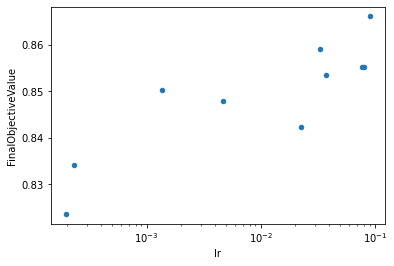

In [8]:
df.plot.scatter(x='lr', y='FinalObjectiveValue')
plt.xscale('log')

<AxesSubplot:xlabel='batch_size', ylabel='FinalObjectiveValue'>

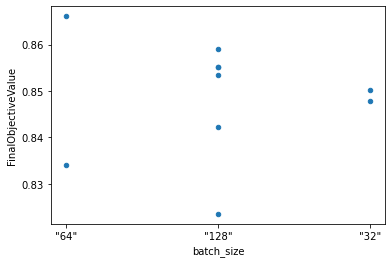

In [10]:
df.plot.scatter(x='batch_size', y='FinalObjectiveValue')

## Deploy best model
Here we will look at two ways of deploying the best model from the hyperparameter search. First we will deploy an endpoint to allow real-time inference, then look at how we can use a Batch Transform to make predictions on a larger dataset.

The path to the best model output is defined below. There is probably a better way to automatically extract this path from the tuning job, but I didn't find it yet.

In [12]:
best_model_s3_path = 's3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/hpo-xray-pneumonia-220402-2121-010-da58b052/output/model.tar.gz'

### Real-time endpoint
#### Default prediction functions
First we will look at how this works if we use the default predictions functions provided by AWS. When we deploy the endpoint it will run a SageMaker PyTorch model server. As detailed [here](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html), we can configure two parts of the inference process; model loading and model serving. This consists of four functions:
- `model_fn`: This tells SageMaker how to load your model and retsurns a model object that can be used for model serving. This must be provided by the user in all cases.
- `input_fn`: Takes the request data and prepares (deserializes) into the correct format for prediction
- `predict_fn`: Takes the output of `input_fn` (i.e. the deserialized request data) and performs inference using the model loaded with `model_fn`.
- `output_fn`: Takes the output of `predict_fn` and serializes the prediction according to the response content type.

At a minimum we must provide a `model_fn` function, which is what we will do for this first example. We can include this in the same script where we put the training code (i.e. `train_model.py`), but it's better to have it in its own script. Here the following is added to the `inference_default.py` script in the `source_dir` directory and used as the `entry_point` for the model.

```
def model_fn(model_dir):
    model = net()
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    return model
```

Now let's use the `PyTorchModel` constructor to create a model object using the best model from the hyperparameter search and the `inference_default.py` entry point.

In [16]:
pytorch_model = PyTorchModel(model_data=best_model_s3_path, 
                             role=SAGEMAKER_ROLE_ARN,
                             entry_point='./source_dir/inference_default.py',
                             framework_version='1.8',
                             py_version='py3')

Next we use the `deploy()` method to deploy this as an endpoint.

In [17]:
predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium") 

-------------!

It may take a few minutes for the endpoint to be created, but once it is done you will be able to see a running endpoint in the AWS SageMaker console.

<p align="center">
    <img src="./imgs/endpoint.png"
    >
</p>
<p align="center">
    <em>Example endpoint running on SageMaker.</em>
</p>





#### *Make predicion using endpoint*

According to the SageMaker [documentation](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html), the default `input_fn` will deserialize JSON, CSV or NPY encoded data into a torch.Tensor. So here we will pass the input data as a NumPy array. Before we can do this we need to prepare the data by applying the relevant data transforms.

In [18]:
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [19]:
val_dataset = ImageFolder(
    './chest_xray/val', 
    transform=val_transforms)

In [20]:
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=True,
    pin_memory=False
)

Let's turn this into an iterator and get a batch of data.

In [21]:
val_dataiter = iter(val_dataloader)
images, labels = val_dataiter.next()

And finally we can try invoking the endpoint to get the model predictions:

In [22]:
outputs = predictor.predict(images.numpy())

In [23]:
outputs

array([[-7.18872738],
       [20.31866837],
       [ 3.50964713],
       [ 9.68861961]])

Notice that the outputs are not yet in the form of predicted labels or probabilities. This is because we used raw logits as the output from the modle, since the loss function also included the Sigmoid activation function. We can convert the values into probabilities by passing through the Sigmoid function, then assigning anything with greater than 50% probability as predicting pneumonia. However, this is also equivalent to saying any raw output that is positive is assigned as predicting pneumonia. Below I plot the input images, true class and predicted class for these four images.

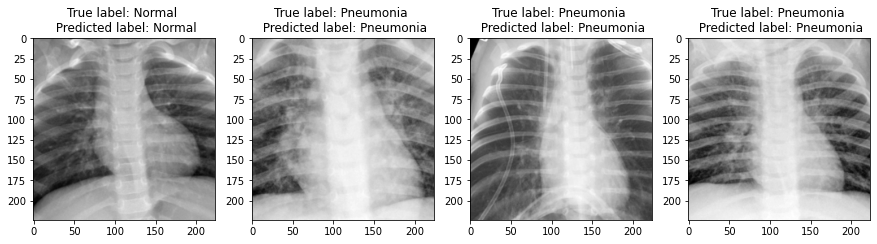

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
for i in range(4):
    img = images[i].numpy()   
    img = np.transpose(img, (1,2,0))
    axs[i].imshow(img[:,:,0], cmap='gray')
    if labels[i].numpy() == 0:
        label = 'Normal'
    elif labels[i].numpy() == 1:
        label = 'Pneumonia'
    if outputs[i] < 0:
        pred_label = 'Normal'
    else:
        pred_label = 'Pneumonia'
    axs[i].set_title(f'True label: {label} \n Predicted label: {pred_label}')

So it looks like the model is doing a good job. Once finished it is very important to delete the endpoint, since you will be charged for the amount of time it is running (not the number of requests).

In [25]:
predictor.delete_endpoint()

#### Custom model serving functions
As we saw above, we can use the default `input_fn`, `predict_fn` and `output_fn` provided by AWS to make a prediction. However, this means that the end user then needs to prepare the data in the correct way before making the request. This makes it more likely for errors to occur. Also, if we want to perform batch predictions (which we will see next), we need to take care of the preprocessing in these functions. 

For this example, the code can be found in the `inference_custom.py` file. When we send a request to an endpoint, the data should be in the form of a byte array. The `input_fn` should extract this from the request body and deserialize it into the correct form for making a prediction with the model. In this case, we are working with JPEG images, so the content type is `image/jpeg`. The input to the `predict_fn` should be a Pillow image, which we use to open the data in the request body.

```
def input_fn(request_body, content_type='image/jpeg'):
    logger.info('Deserializing input data')
    logger.info(f'Request content type: {type(request_body)}')
    if content_type == 'image/jpeg':
        logger.info('Loading image')
        return Image.open(io.BytesIO(request_body))
    elif content_type == 'application/json':
        img_request = requests.get(request_body['url'], stream=True)
        return Image.open(io.BytesIO(img_request.content))
    raise Exception(f'Unsupported content type ({type(request_body)}). Expected image/jpeg')
```

The output from this is passed to the `predict_fn`. Here I apply the transformation that need to be applied to the image before passing it through the model.

```
def predict_fn(input_object, model):
    logger.info('Starting predict function')

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)
    
    # Transform data
    test_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
        ])

    logger.info('Passing data through image transformations')
    input_object = test_transforms(input_object)
    logger.info(f'Input mean: {np.mean(input_object.numpy().flatten())}')
    logger.info(f'Input std: {np.std(input_object.numpy().flatten())}')

    with torch.no_grad():
        logger.info(f'Making prediction on input object')
        logger.info(f'Input object type is {type(input_object)}')
        logger.info(f'Input object size is {input_object.shape}')
        prediction = model(input_object.unsqueeze(0).to(device).item())
        logger.info(f'Output from PyTorch model: {prediction}')
    
    return prediction
```

**Important**: Make sure to put the model in evaluation model (i.e. `model.eval()`), else you will get strange output predictions.

The `output_fn` is used to process the output from `predict_fn` into the correct content type for sending back the response from the endpoint. Here I am just using the default function, which expects the output from `predict_fn` to be a `torch.Tensor` and can serialize the data as either JSON, CSV or NPY.

One final thing we need before deploying an endpoint with these custom inference functions is a function to call to create a predictor with and endpoint name and SageMaker session. To do this, we create the `ImagePredictor` class below, which inherits from the `Predictor` class. We then overide the input serializer and output deserializer to fit our use case.

In [27]:
jpeg_serializer = IdentitySerializer("image/jpeg")
numpy_deserializer = NumpyDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=jpeg_serializer, 
                         deserializer=numpy_deserializer, content_type='image/jpeg')

Finally, we can deploy a new endpoint using the custom model serving functions. Note we need to include the `predictor_cls` in the parameters which tells it how to create a predictor. 

In [32]:
pytorch_model = PyTorchModel(model_data=best_model_s3_path, 
                             role=SAGEMAKER_ROLE_ARN,
                             source_dir='source_dir',
                             entry_point='inference_custom.py',
                             framework_version='1.8',
                             py_version='py3',
                             predictor_cls=ImagePredictor)

In [33]:
predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium") 

-----------!

content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### *Make prediction using endpoint*
Now we can invole this endpoint to make predictions. Unlike in the previous example, where we needed to first prepare the data, here we just provide the raw input images in the form of bytes. The code below loops through 20 example normal X-rays to test the endpoint.

In [34]:
local_train_normal_dir = f'{LOCAL_DATA_DIR}/train/NORMAL'
im_files = os.listdir(local_train_normal_dir)

predictions = []
for i in range(20):
    image_bytes = open(os.path.join(local_train_normal_dir, im_files[i]), 'rb').read()
    prediction = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})
    predictions.append(prediction)

In [35]:
predictions

[array([[-15.69345951]]),
 array([[-14.34248066]]),
 array([[-6.92042255]]),
 array([[-20.93902969]]),
 array([[-15.46013165]]),
 array([[-11.79647064]]),
 array([[-12.07676697]]),
 array([[-4.57924128]]),
 array([[-16.30091286]]),
 array([[-16.97775078]]),
 array([[-21.54648781]]),
 array([[-17.23729897]]),
 array([[-12.55500507]]),
 array([[-5.83817482]]),
 array([[-17.56958389]]),
 array([[1.16742909]]),
 array([[-11.71478748]]),
 array([[-13.61980343]]),
 array([[-10.55872536]]),
 array([[-16.16726494]])]

As we can see, the predictions are returned in the form of a NumPy array. In this case, all but one of the predictions are correct (negative values will be predicted as normal X-rays).

Finally, we must remember to delete the endpoint to avoid incurring unnecessary charges.

In [36]:
predictor.delete_endpoint()

### Batch transform
Finally, we see how we can make predictions using Batch Transform. This is useful when we want to run predictions on a set of data rather than doing things in real-time. See the [Batch transform](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_batch_transform/pytorch_mnist_batch_transform/pytorch-mnist-batch-transform.html) for more details.

We start by creating a `PyTorchModel` object from a saved model artifact (again the best model from the hyperparameter search).

In [37]:
pytorch_model = PyTorchModel(model_data=best_model_s3_path, 
                             role=SAGEMAKER_ROLE_ARN,
                             source_dir='source_dir',
                             entry_point='inference_custom.py',
                             framework_version='1.8',
                             py_version='py3')

Next we create a transformer from the `PyTorchModel` object.

In [38]:
transformer = pytorch_model.transformer(instance_count=1, instance_type="ml.m5.xlarge")

Now we can perform inference using this transformer. Here we will pass the validation data stored in the S3 bucket to return the predictions for all of the validation data. In this case we must set the `data_type` parameter as `S3Prefix` and the `content_type` as `image/jpeg`.

In [39]:
transform_inputs = 's3://robsmith155-courses/udacity-aws-nd/course3/project/data/val/'

In [40]:
transformer.transform(
    data=transform_inputs,
    data_type="S3Prefix",
    content_type="image/jpeg",
    wait=True
)

............................Collecting wandb
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=eae4ef845309b2b29f91a670da2cced49d545b0bdb1d8e4d31dc5b86f5e9d8ee
  Stored in directory: /root/.cache/pip/wheels/59/9a/1d/3f1afbbb5122d0410547bf9eb50955f4a7a98e53a6d8b99bd1
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ad51d8312811352fd31dfc6317ec1e78d97765a97b329743142d5fef9db27b58
  Stored in directory: /root/.cache/pip/wheels/42/ea/90/e37d463fb3b03848bf715080595de62545266f53dd546b2497
Successfully built promise pathtools
2022-04-09 09:34:00,675 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2022-04-09 09:34:00,811 [INFO ] main org.pytorch.serve.ModelServer - 
Torch

#### QC results
The results of the batch transform are stored in an S3 bucket. We can determine where they were stored using the `output_path` attribute.

In [42]:
transformer_output_path = transformer.output_path
transformer_output_path

's3://sagemaker-us-east-1-377574710449/pytorch-inference-2022-04-09-09-29-00-380'

Now we are going to use the `boto3` SDK to retrieve the predictions from the S3 bucket.

In [43]:
output_bucket_name, output_path = transformer.output_path.replace("s3://", "").split("/", 1)
output_bucket_name, output_path

('sagemaker-us-east-1-377574710449',
 'pytorch-inference-2022-04-09-09-29-00-380')

In [44]:
conn = boto3.client('s3')
contents = conn.list_objects_v2(Bucket=output_bucket_name, Prefix=output_path)['Contents']

In [112]:
len(contents)

320

We can see that it contains 320 items, which is the number of validation images. Now lets loop over these contents to retrieve the predictions and compare them to the true labels.

In [45]:
def sigmoid(data):
    z = 1/(1 + np.exp(-data))
    return z

In [46]:
y_prob, y_pred, y_true, img_names = [], [], [], []
for i in range (len(contents)):
    img_folder = contents[i]['Key'].split('/')[-2]
    if img_folder == 'NORMAL':
        img_label = 0
    else:
        img_label = 1
    img_name = contents[i]['Key'].split('/')[-1][:-4]
    response = conn.get_object(Bucket=output_bucket_name, Key=contents[i]['Key'])
    body = response['Body']
    data = json.loads(body.read())[0][0]
    prob = sigmoid(data)
    if prob < 0.5:
        pred = 0
    else:
        pred = 1
    img_names.append(img_name)
    y_prob.append(prob)
    y_pred.append(pred)
    y_true.append(img_label)
    

Let's plot the results as a confusion matrix.

In [47]:
cf_matrix = confusion_matrix(y_true, y_pred)

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

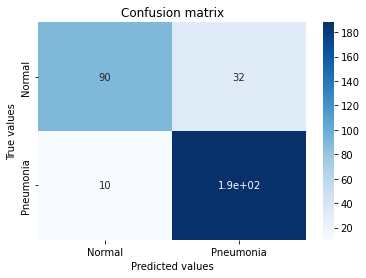

In [48]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted values')
ax.set_ylabel('True values')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])

So out of the 320 validation images, 270 were correctly classified while 50 were misclassified. In this case, normal X-rays being classified as having pneumonia was more common (32 instances) than pneumonia X-rays misclassified as being normal. It's probably preferable that this is the case, rather than the other way around.

Is this a useful results? The F1 score for the validation data is:

In [49]:
val_f1_pred = f1_score(y_true, y_pred)
val_f1_pred

0.8995215311004785

Since the dataset has more pneumonia images than normal, a naive model would be to predict every image as having pneumonia. In this case, our baseline F1 score would be:

In [52]:
y_pred_naive = [1] * len(y_true)
baseline_f1 = f1_score(y_true, y_pred_naive)
baseline_f1

0.7644787644787645

So we have a useful result, although there are still many things we can do to improve the model (see the end of the notebook for suggestions). Once we are happy with the model then we should re-run the above analysis on the test data, but we don't want to keep doing this as we can then bias the results.

#### *Uncertain predictions*
We can also look at the X-rays which were most uncertain. These are images which have a probability of close to 50%.

In [53]:
def plot_uncertain_predictions(y_prob, y_true, img_names):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.suptitle('Most uncertain X-ray predictions')

    img_idxs = np.argsort(np.abs(np.array(y_prob)-0.5))
    for i, ax in enumerate(axes.ravel()):
        if y_true[img_idxs[i]] == 0:
            true_label = 'NORMAL'
        else:
            true_label = 'PNEUMONIA'
        im_path = f'{LOCAL_DATA_DIR}/val/{true_label}/{img_names[img_idxs[i]]}'
        ax.imshow(np.array(Image.open(im_path)), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Output pneumonia probability: {y_prob[img_idxs[i]]} \n True label: {true_label}')

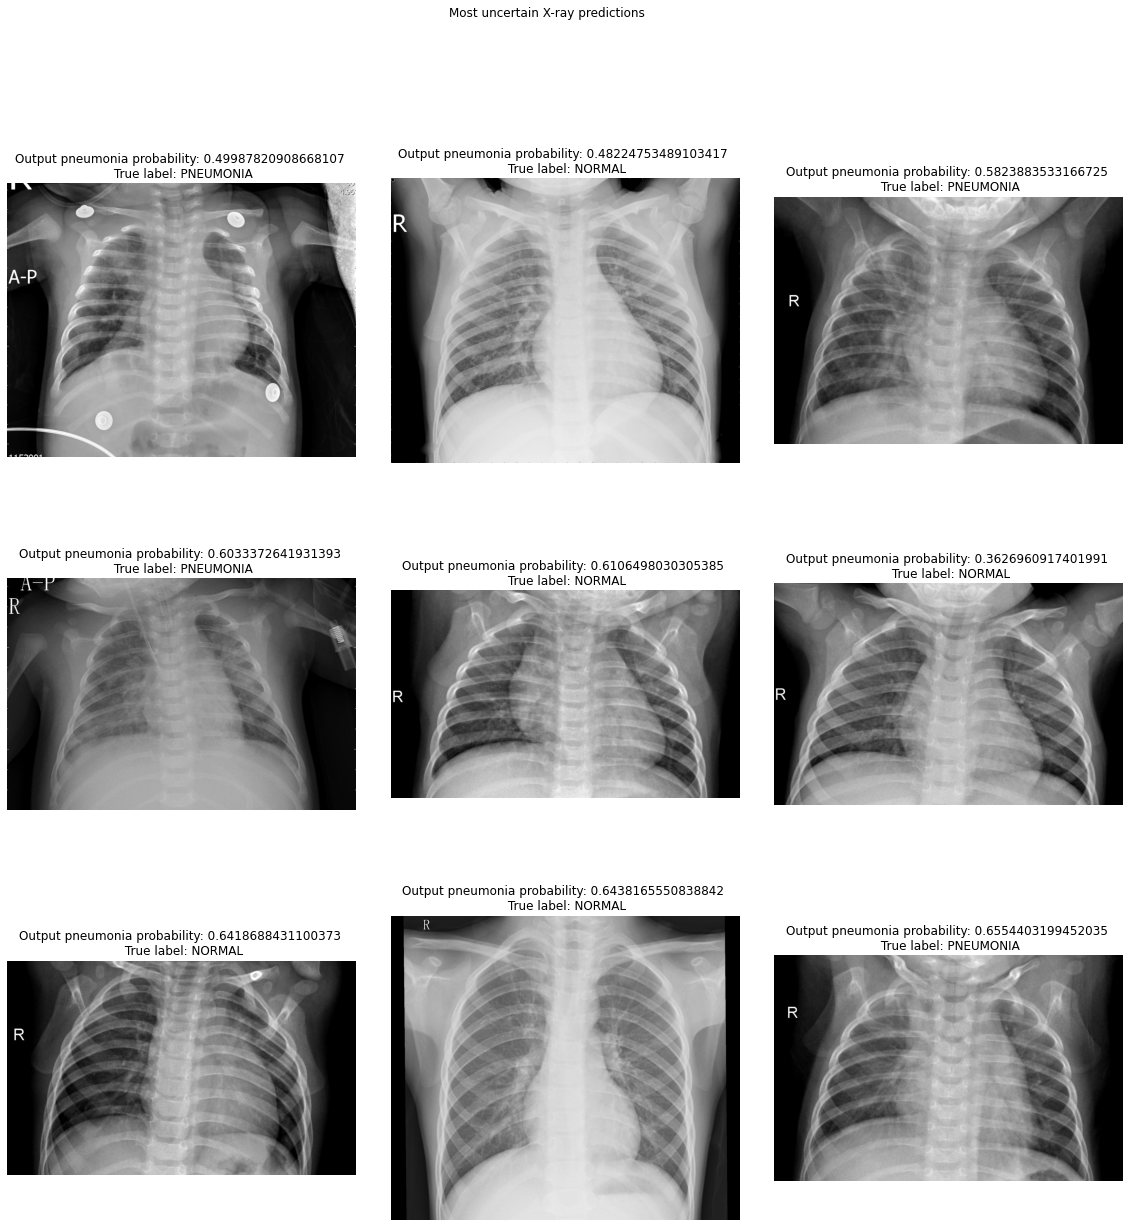

In [54]:
plot_uncertain_predictions(y_prob, y_true, img_names)

## Areas for improvement
Here we focused on developing an end-to-end workflow that allows us to upload our data to S3, run hyperparameter turning, and deploy the final model to a SageMaker endpoint. There are many things that we could do to try to improve the performance of the model, including:

- **Oversampling minority class**: We saw before that we have an imbalanced training dataset, with around three pneumonia X-rays for every normal image. One way we can try to account for this is to sample the normal X-rays multiple times until we have the same number as the pneumonia samples.
- **Weighted loss function**: I forgot to add a weighting to the loss function. This would penalize mistakes with the minority class (in this case normal X-rays) more than those with pneumonia. However, we need to consider this carefully. Maybe it is better if a normal X-ray is mis-classified as pneumonia, so at least a radiologist can look at it in more detail. This might be preferable to misclassifying an X-ray with signs of pneumonia as being normal.
- **Extend fine-tuning**: Currently the model training only updates the weights in the very final layer of the model (fully connected layer). However, we can also fine-tune early layers (i.e. the convolutional part) of the model.